In [1]:
import pandas as pd               
from pathlib import Path           

DATA_ROOT = Path("/Users/v/Desktop/Visual/glaucoma_DL_project/data/uwhvf-master/CSV")
VF_PATH = DATA_ROOT / "VF_Data.csv"   

df = pd.read_csv(VF_PATH)

print("rows, cols:", df.shape)

df.head()

rows, cols: (28943, 184)


,PatID,Gender,Eye,FieldN,Age,Time_from_Baseline,MS,MS_Cluster1,MS_Cluster2,MS_Cluster3,...,PD_45,PD_46,PD_47,PD_48,PD_49,PD_50,PD_51,PD_52,PD_53,PD_54
0,647,F,Right,1,52.7967,0.0000,27.832885,25.57750,26.979231,30.588333,...,-1.92,-0.36,-0.44,-1.52,-0.03,-1.06,0.75,-1.33,-2.02,-0.61
1,647,F,Right,2,53.8234,1.0267,30.131346,27.76000,29.911538,33.263333,...,-0.54,-1.13,-1.81,-1.74,-2.19,-1.23,-4.85,-2.24,0.00,0.28
2,647,F,Right,3,54.8857,2.0890,29.454808,25.47500,29.826154,32.488333,...,-0.07,1.56,-2.09,0.07,-0.84,-2.45,-0.48,-4.10,-1.28,-4.07
3,647,F,Right,4,57.7331,4.9363,27.947885,23.75625,28.658462,31.431667,...,-2.57,-1.74,-0.52,-2.70,-1.48,-3.32,-3.00,-6.49,-2.19,-2.76
4,647,F,Right,5,58.7680,5.9713,27.644038,24.90250,28.104615,30.105000,...,-0.80,-0.93,-3.08,-2.55,-3.26,-3.13,-1.42,-0.18,-1.02,-2.63


In [ ]:
import pandas as pd
import numpy as np


# 0) Load the dataset

df = pd.read_csv("/Users/v/Desktop/Visual/glaucoma_DL_project/data/uwhvf-master/CSV/VF_Data.csv")
print("Dataset shape:", df.shape)
print("Example columns:", df.columns[:10].tolist())


# 1) Age correction (no clipping): 
#    Treat Age<10 or Age≈Time_from_Baseline as suspicious; 
#    reconstruct using per-patient baseline or global baseline median.

def correct_age_per_patient_v2(df):
    d = df.copy()

    # Suspicious ages: too low for perimetry OR looks like a mis-entry equals follow-up time
    suspect = (d["Age"] < 10) | (np.isclose(d["Age"], d["Time_from_Baseline"], atol=0.1))

    # Global baseline median as fallback (use entries with Age >= 10)
    valid_for_baseline = d["Age"] >= 10
    base_candidates = (d.loc[valid_for_baseline, "Age"] - d.loc[valid_for_baseline, "Time_from_Baseline"]).to_numpy()
    base_candidates = base_candidates[np.isfinite(base_candidates)]
    global_base_med = float(np.median(base_candidates)) if base_candidates.size > 0 else 60.0

    # Reconstruct age per patient: baseline_est + Time_from_Baseline
    d["Age_reconstructed"] = np.nan
    for pid, g in d.groupby("PatID", sort=False):
        g_valid = g["Age"] >= 10
        if g_valid.any():
            cand = (g.loc[g_valid, "Age"] - g.loc[g_valid, "Time_from_Baseline"]).to_numpy()
            cand = cand[np.isfinite(cand)]
            baseline = float(np.median(cand)) if cand.size > 0 else global_base_med
        else:
            baseline = global_base_med
        d.loc[g.index, "Age_reconstructed"] = baseline + g["Time_from_Baseline"].values

    # Replace only suspicious ages with the reconstructed values; no clipping to [18, 90]
    d["Age"] = d["Age"].where(~suspect, d["Age_reconstructed"])

    return d

dfc = correct_age_per_patient_v2(df)


# 2) Helpers

def median_iqr(series, nd=2):
    s = pd.to_numeric(series, errors="coerce").dropna().to_numpy()
    q25, q75 = np.percentile(s, [25, 75])
    return f"{np.median(s):.{nd}f} [{q25:.{nd}f}, {q75:.{nd}f}]"

def per_eye_temporal_stats(df_in):
    """Compute per-eye temporal features: number of tests, avg interval, follow-up span."""
    eye_id = ["PatID","Eye"]
    df_sorted = df_in.sort_values(eye_id + ["Time_from_Baseline"])
    stats = []
    for (pid, eye), g in df_sorted.groupby(eye_id, sort=False):
        t = pd.to_numeric(g["Time_from_Baseline"], errors="coerce").sort_values().dropna().to_numpy()
        n = len(t)
        if n >= 2:
            intervals = np.diff(t)
            avg_interval = float(np.mean(intervals))
            time_span = float(t.max() - t.min())
        else:
            avg_interval = np.nan
            time_span = 0.0 if n == 1 else np.nan
        stats.append({
            "PatID": pid,
            "Eye": eye,
            "num_tests": n,
            "avg_interval": avg_interval,
            "time_span": time_span
        })
    return pd.DataFrame(stats)


# 3) Build "baseline per eye" cohort (same scope as the paper)

df_base = (
    dfc.sort_values(["PatID","Eye","Time_from_Baseline"])
       .groupby(["PatID","Eye"], as_index=False)
       .first()
)

# Adult-only for Table-1-like reporting (the paper cohort is adult glaucoma)
df_base_adult = df_base[df_base["Age"] >= 18].copy()


# 4) outputs 1


# 4.1 Baseline age (median [IQR])
age_miqr = median_iqr(df_base_adult["Age"], nd=0)

# 4.2 Gender counts and proportions (based on baseline-per-eye)
gender_counts = df_base_adult["Gender"].value_counts(dropna=False)
gender_total = int(gender_counts.sum())

def fmt_gender_row(label, count):
    pct = 100.0 * count / gender_total if gender_total > 0 else 0.0
    return f"{label}: {count} ({int(round(pct,0))}%)"

# Normalize labels to match your desired display (F/M/None/O)
label_map = {"F":"F", "M":"M", "None":"None", "O":"O"}
display_labels = ["F","M","None","O"]
gender_lines = []
for lab in display_labels:
    # Find all categories that map to this label (robust to odd encodings)
    match = [k for k in gender_counts.index.astype(str) if label_map.get(k, k) == lab]
    count = int(gender_counts.loc[gender_counts.index.astype(str).isin(match)].sum()) if match else 0
    gender_lines.append(fmt_gender_row(lab, count))

# 4.3 Per-eye temporal stats on the full corrected dataset, but report medians on the eligible subset (num_tests ≥ 2)
eye_stats = per_eye_temporal_stats(dfc)
eligible = eye_stats[eye_stats["num_tests"] >= 2].copy()  # same spirit as paper when computing intervals and span

numtests_miqr = median_iqr(eligible["num_tests"], nd=2)
avgint_miqr = median_iqr(eligible["avg_interval"], nd=2)
timespan_miqr = median_iqr(eligible["time_span"], nd=2)

# 4.4 Baseline PSD / MTD (global + cluster-wise) on baseline-per-eye adult subset
psd_miqr = median_iqr(df_base_adult["PSD"], nd=2)
mtd_miqr = median_iqr(df_base_adult["MTD"], nd=2)

cluster_lines = []
cluster_ok = all([(f"MTD_Cluster{i}" in df_base_adult.columns) for i in range(1,7)])
if cluster_ok:
    for i in range(1,7):
        cluster_lines.append(f"  Cluster {i}: {median_iqr(df_base_adult[f'MTD_Cluster{i}'], nd=2)}")
else:
    cluster_lines.append("  (Cluster columns not found; skipping cluster-wise MTD.)")

# ----- Print Table-1-like block -----
print(f"Baseline age (y), median [IQR] = {age_miqr}\n")
for line in gender_lines:
    print(line)
print(f"\nFollow-up length (y), median [IQR] = {timespan_miqr}")
print(f"Number of tests (per eye), median [IQR] = {numtests_miqr}")
print(f"Average intertest interval (y), median [IQR] = {avgint_miqr}\n")
print(f"Baseline PSD (dB), median [IQR] = {psd_miqr}")
print(f"Baseline MTD (dB), median [IQR] - Global = {mtd_miqr}")
for line in cluster_lines:
    print(line)


# 5) Descriptive stats (mean/min/max/std) on the corrected full dataset

print("\n===== Descriptive statistics for Age, MS, MTD, PSD =====")
key_cols = ["Age","MS","MTD","PSD"]
desc = dfc[key_cols].apply(pd.to_numeric, errors="coerce").describe()
print(desc.loc[["mean","min","max","std"]].T)

Dataset shape: (28943, 184)
Example columns: ['PatID', 'Gender', 'Eye', 'FieldN', 'Age', 'Time_from_Baseline', 'MS', 'MS_Cluster1', 'MS_Cluster2', 'MS_Cluster3']
Baseline age (y), median [IQR] = 64 [54, 73]

F: 3054 (41%)
M: 2594 (35%)
None: 1725 (23%)
O: 4 (0%)

Follow-up length (y), median [IQR] = 2.50 [1.12, 5.05]
Number of tests (per eye), median [IQR] = 3.00 [2.00, 5.00]
Average intertest interval (y), median [IQR] = 1.13 [0.84, 1.62]

Baseline PSD (dB), median [IQR] = 2.41 [1.69, 5.35]
Baseline MTD (dB), median [IQR] - Global = -4.49 [-7.97, -2.64]
  Cluster 1: -4.58 [-9.00, -2.21]
  Cluster 2: -4.50 [-7.98, -2.58]
  Cluster 3: -3.54 [-6.32, -2.11]
  Cluster 4: -4.08 [-6.92, -2.56]
  Cluster 5: -4.45 [-8.00, -2.53]
  Cluster 6: -4.07 [-7.22, -2.16]

===== Descriptive statistics for Age, MS, MTD, PSD =====
          mean       min        max        std
Age  64.531649   7.83300  89.995900  14.347499
MS   24.955397   0.00000  49.406154   6.355391
MTD  -6.818922 -32.94750  18.149231 

===== Global Summary (Baseline per eye, adults; same as paper) =====
Age: 64 [54, 73]
MS: 27.33 [23.63, 29.43]
MTD: -4.49 [-7.97, -2.64]
PSD: 2.41 [1.69, 5.35]


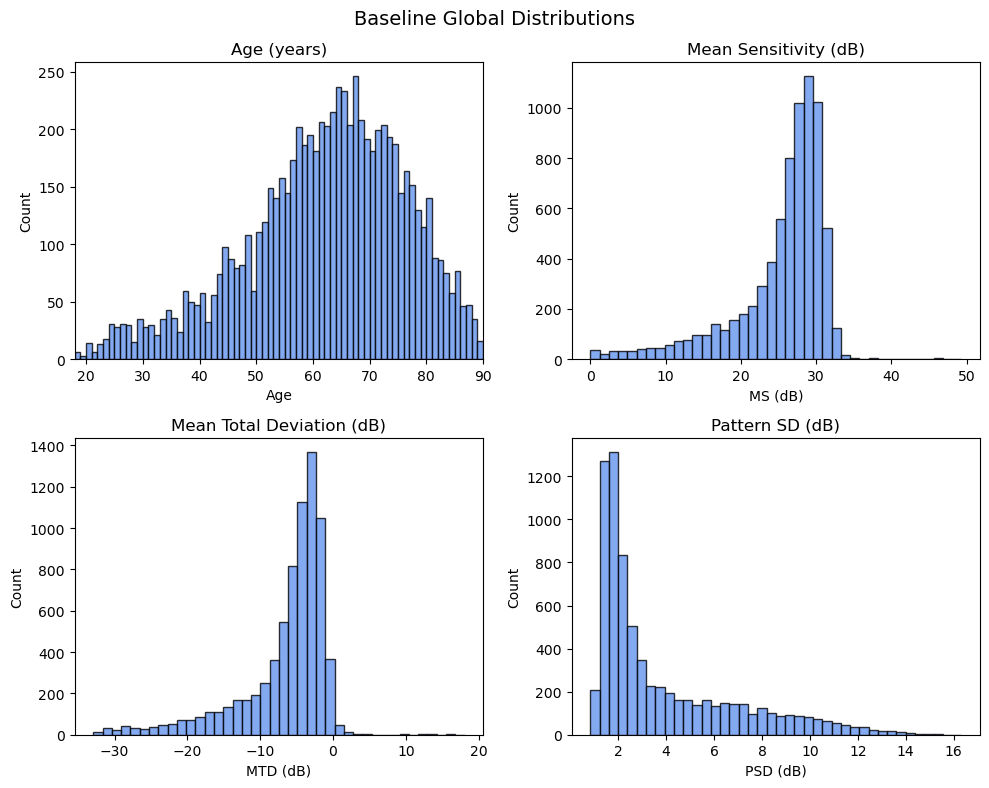

Saved figure -> /Users/v/Desktop/Visual/glaucoma_DL_project/results/figures/baseline_global_histograms.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -------- 1) Baseline-per-eye + Adult filter (match paper scope) --------
df_base = (
    dfc.sort_values(["PatID", "Eye", "Time_from_Baseline"])
       .groupby(["PatID", "Eye"], as_index=False)
       .first()
)
df_base_adult = df_base[pd.to_numeric(df_base["Age"], errors="coerce") >= 18].copy()

def median_iqr(series, nd=2):
    s = pd.to_numeric(series, errors="coerce").dropna().to_numpy()
    q25, q75 = np.percentile(s, [25, 75])
    return f"{np.median(s):.{nd}f} [{q25:.{nd}f}, {q75:.{nd}f}]"

print("===== Global Summary (Baseline per eye, adults; same as paper) =====")
print(f"Age: {median_iqr(df_base_adult['Age'], 0)}")
print(f"MS: {median_iqr(df_base_adult['MS'], 2)}")
print(f"MTD: {median_iqr(df_base_adult['MTD'], 2)}")
print(f"PSD: {median_iqr(df_base_adult['PSD'], 2)}")

# -------- 2) Plot histograms (save to disk) --------
out_dir = Path("/Users/v/Desktop/Visual/glaucoma_DL_project/results/figures")
out_dir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# 2.1 Age: 1-year bins starting at 18; optional jitter for exact-18 values (plot-only)
age = pd.to_numeric(df_base_adult["Age"], errors="coerce").dropna()
age = age[(age >= 18) & (age <= 90)]

age_bins = np.arange(18, 91, 1)
axes[0].hist(age, bins=age_bins, color="cornflowerblue", edgecolor="black", alpha=0.8)
axes[0].set_title("Age (years)")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")
axes[0].set_xlim(18, 90)

# 2.2 MS
ms = pd.to_numeric(df_base_adult["MS"], errors="coerce").dropna()
axes[1].hist(ms, bins=40, color="cornflowerblue", edgecolor="black", alpha=0.8)
axes[1].set_title("Mean Sensitivity (dB)")
axes[1].set_xlabel("MS (dB)")
axes[1].set_ylabel("Count")

# 2.3 MTD
mtd = pd.to_numeric(df_base_adult["MTD"], errors="coerce").dropna()
axes[2].hist(mtd, bins=40, color="cornflowerblue", edgecolor="black", alpha=0.8)
axes[2].set_title("Mean Total Deviation (dB)")
axes[2].set_xlabel("MTD (dB)")
axes[2].set_ylabel("Count")

# 2.4 PSD
psd = pd.to_numeric(df_base_adult["PSD"], errors="coerce").dropna()
axes[3].hist(psd, bins=40, color="cornflowerblue", edgecolor="black", alpha=0.8)
axes[3].set_title("Pattern SD (dB)")
axes[3].set_xlabel("PSD (dB)")
axes[3].set_ylabel("Count")

fig.suptitle("Baseline Global Distributions", fontsize=14)
plt.tight_layout()

save_path = out_dir / "baseline_global_histograms.png"
plt.savefig(save_path, dpi=200)
plt.show()
print(f"Saved figure -> {save_path}")

===== Per-Eye Summary =====
Number of tests (per eye), median [IQR] = 5.00 [4.00, 7.00]
Average interval (y), median [IQR] = 1.21 [0.98, 1.56]
Follow-up length (y), median [IQR] = 5.29 [3.66, 9.99]


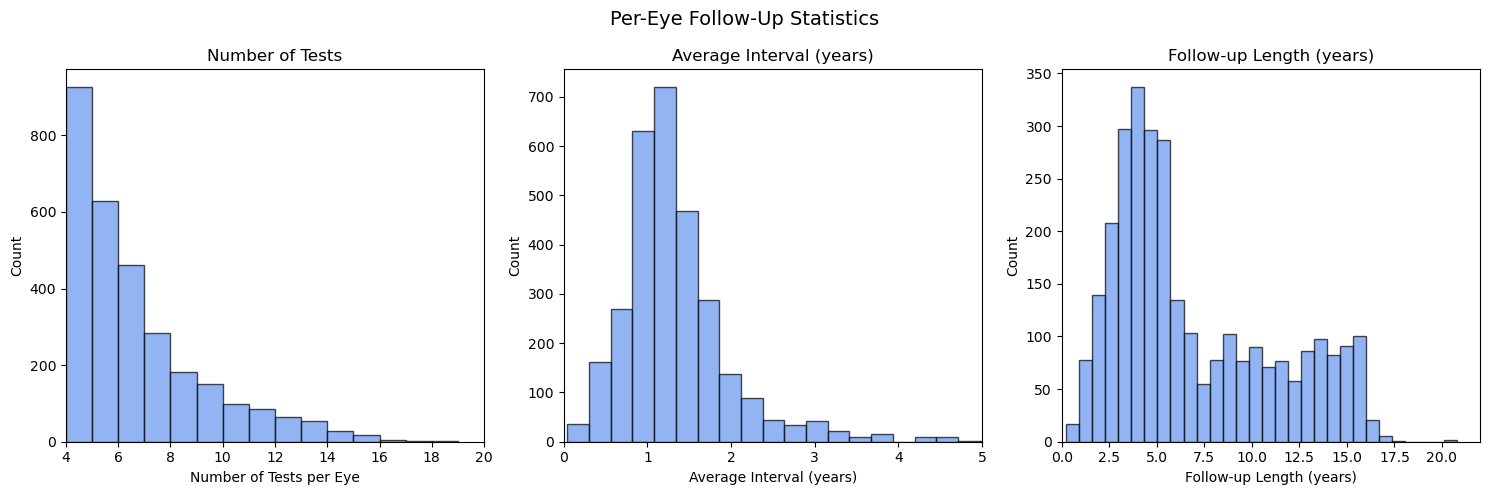

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Select eligible eyes with at least 4 tests
eligible = eye_stats[eye_stats["num_tests"] >= 4].copy()

# Function to compute median and IQR
def median_iqr(s):
    q1, q3 = s.dropna().quantile([0.25, 0.75])
    return f"{s.median():.2f} [{q1:.2f}, {q3:.2f}]"

# Print summary table
print("===== Per-Eye Summary =====")
print(f"Number of tests (per eye), median [IQR] = {median_iqr(eligible['num_tests'])}")
print(f"Average interval (y), median [IQR] = {median_iqr(eligible['avg_interval'])}")
print(f"Follow-up length (y), median [IQR] = {median_iqr(eligible['time_span'])}")

# Create 3 horizontally aligned histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Number of tests per eye
axes[0].hist(eligible["num_tests"], bins=np.arange(4, eligible["num_tests"].max() + 1, 1),
             color="cornflowerblue", edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Number of Tests per Eye")
axes[0].set_ylabel("Count")
axes[0].set_xlim(4, max(20, eligible["num_tests"].max()))
axes[0].set_title("Number of Tests")

# Plot 2: Average time interval between tests
axes[1].hist(eligible["avg_interval"], bins=20, color="cornflowerblue",
             edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Average Interval (years)")
axes[1].set_ylabel("Count")
axes[1].set_xlim(0, 5)
axes[1].set_title("Average Interval (years)")

# Plot 3: Total follow-up time span
axes[2].hist(eligible["time_span"], bins=30, color="cornflowerblue",
             edgecolor="black", alpha=0.7)
axes[2].set_xlabel("Follow-up Length (years)")
axes[2].set_ylabel("Count")
axes[2].set_xlim(0, 22)
axes[2].set_title("Follow-up Length (years)")

# Global title
fig.suptitle("Per-Eye Follow-Up Statistics", fontsize=14)
plt.tight_layout()
plt.show()

===== Glaucoma Stage Classification (HFA) =====
0: Normal: 113 eyes (1.5%)
1: Mild: 3972 eyes (53.8%)
2: Moderate: 2183 eyes (29.6%)
3: Severe: 723 eyes (9.8%)
4: Advanced: 386 eyes (5.2%)


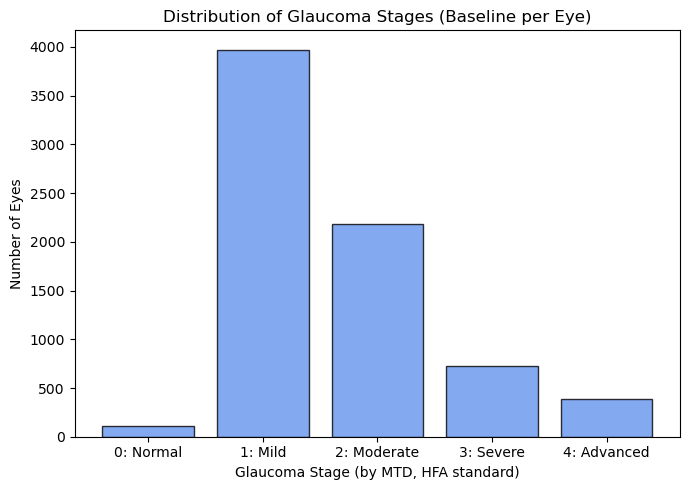

In [34]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define HFA classification based on Mean Deviation (MD or MTD)
def classify_stage_hfa(md):
    if md >= 0:
        return 0  # normal
    elif md < 0 and md >= -5:
        return 1  # mild
    elif md < -5 and md >= -12:
        return 2  # moderate
    elif md < -12 and md >= -20:
        return 3  # severe
    elif md < -20:
        return 4  # advanced

# Apply to baseline-per-eye adult dataset
df_base_adult["Stage"] = df_base_adult["MTD"].apply(classify_stage_hfa)

# Count distribution of stages
stage_counts = df_base_adult["Stage"].value_counts().sort_index()
stage_labels = ["0: Normal", "1: Mild", "2: Moderate", "3: Severe", "4: Advanced"]

# Print numerical summary
print("===== Glaucoma Stage Classification (HFA) =====")
for i, label in enumerate(stage_labels):
    n = stage_counts.get(i, 0)
    pct = n / len(df_base_adult) * 100
    print(f"{label}: {n} eyes ({pct:.1f}%)")

# Plot stage distribution
plt.figure(figsize=(7, 5))
plt.bar(stage_labels, stage_counts.sort_index(), color="cornflowerblue", edgecolor="black", alpha=0.8)
plt.xlabel("Glaucoma Stage (by MTD, HFA standard)")
plt.ylabel("Number of Eyes")
plt.title("Distribution of Glaucoma Stages (Baseline per Eye)")
plt.tight_layout()
plt.show()

In [47]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import linregress

# Load the corrected dataset (use dfc if available, otherwise load from CSV)
try:
    df_use = dfc.copy()
except NameError:
    data_path = "/Users/v/Desktop/Visual/glaucoma_DL_project/data/uwhvf-master/CSV/VF_Data.csv"
    df_use = pd.read_csv(data_path)

df_use["Time_from_Baseline"] = pd.to_numeric(df_use["Time_from_Baseline"], errors="coerce")

# Perform per-eye linear regression for a given variable
def regress_per_eye(df, value_col, min_visits=4):
    rows = []
    eye_id = ["PatID", "Eye"]
    sub = df[eye_id + ["Time_from_Baseline", value_col]].dropna(subset=["Time_from_Baseline", value_col])
    groups = sub.sort_values(eye_id + ["Time_from_Baseline"]).groupby(eye_id, sort=False)

    for (pid, eye), g in groups:
        if len(g) < min_visits:
            continue
        t = g["Time_from_Baseline"].to_numpy()
        y = g[value_col].to_numpy()
        if (t.max() - t.min()) <= 0:
            continue
        lr = linregress(t, y)
        rows.append({
            "PatID": pid,
            "Eye": eye,
            "slope": lr.slope,          # annual rate of change (dB/year)
            "intercept": lr.intercept   # estimated baseline value (t = 0)
        })
    return pd.DataFrame(rows)

# Columns to be analyzed: global and cluster-wise MS/MTD
ms_cols  = ["MS"] + [f"MS_Cluster{i}"  for i in range(1, 7)]
mtd_cols = ["MTD"] + [f"MTD_Cluster{i}" for i in range(1, 7)]

# Compute median and IQR of regression results across all eyes
def summarize_regression(df, cols):
    out = []
    for col in cols:
        reg = regress_per_eye(df, col, min_visits=4)
        if reg.empty:
            med_s, q1_s, q3_s = np.nan, np.nan, np.nan
            med_i, q1_i, q3_i = np.nan, np.nan, np.nan
        else:
            s = reg["slope"].to_numpy()
            i = reg["intercept"].to_numpy()
            med_s, q1_s, q3_s = np.median(s), np.percentile(s, 25), np.percentile(s, 75)
            med_i, q1_i, q3_i = np.median(i), np.percentile(i, 25), np.percentile(i, 75)
        out.append({
            "metric": col,
            "slope_median": med_s, "slope_q25": q1_s, "slope_q75": q3_s,
            "intercept_median": med_i, "intercept_q25": q1_i, "intercept_q75": q3_i
        })
    return pd.DataFrame(out)

ms_summary  = summarize_regression(df_use, ms_cols)
mtd_summary = summarize_regression(df_use, mtd_cols)

# Helper function to format median [IQR]
def fmt_miqr(m, q1, q3, nd=2):
    if np.isnan(m):
        return "NA"
    return f"{m:.{nd}f} [{q1:.{nd}f}, {q3:.{nd}f}]"

# Print a paper-style summary table
print("===== Median [IQR] Statistics for Global and Clusterwise Parameters From Linear Regression =====")
print("Row                  MS Intercept      MS Slope         MTD Intercept     MTD Slope")

rows = []
for i in range(len(ms_cols)):
    ms_row  = ms_summary.iloc[i]
    mtd_row = mtd_summary.iloc[i]
    name = "Global" if i == 0 else f"Cluster {i}"

    ms_int  = fmt_miqr(ms_row["intercept_median"], ms_row["intercept_q25"], ms_row["intercept_q75"], nd=2)
    ms_slp  = fmt_miqr(ms_row["slope_median"],     ms_row["slope_q25"],     ms_row["slope_q75"],     nd=2)
    mtd_int = fmt_miqr(mtd_row["intercept_median"], mtd_row["intercept_q25"], mtd_row["intercept_q75"], nd=2)
    mtd_slp = fmt_miqr(mtd_row["slope_median"],     mtd_row["slope_q25"],     mtd_row["slope_q75"],     nd=2)

    print(f"{name:<10}     {ms_int:<16}  {ms_slp:<14}  {mtd_int:<16}  {mtd_slp}")
    rows.append([name, ms_int, ms_slp, mtd_int, mtd_slp])

# Save the summary as CSV
table2_df = pd.DataFrame(rows, columns=["Row", "MS_Intercept", "MS_Slope", "MTD_Intercept", "MTD_Slope"])
out_csv = Path("/Users/v/Desktop/Visual/glaucoma_DL_project/results/table2_like_linear_regression_summary.csv")
out_csv.parent.mkdir(parents=True, exist_ok=True)
table2_df.to_csv(out_csv, index=False)
print("\nSaved:", out_csv)

===== Median [IQR] Statistics for Global and Clusterwise Parameters From Linear Regression =====
Row                  MS Intercept      MS Slope         MTD Intercept     MTD Slope
Global         27.63 [23.91, 29.55]  -0.16 [-0.45, 0.05]  -4.28 [-7.81, -2.49]  -0.10 [-0.40, 0.11]
Cluster 1      25.29 [20.85, 27.73]  -0.15 [-0.53, 0.14]  -4.19 [-8.73, -2.04]  -0.08 [-0.46, 0.22]
Cluster 2      27.55 [23.89, 29.47]  -0.13 [-0.45, 0.09]  -4.34 [-7.85, -2.48]  -0.07 [-0.39, 0.15]
Cluster 3      30.52 [27.72, 32.07]  -0.13 [-0.44, 0.08]  -3.48 [-6.23, -2.05]  -0.07 [-0.38, 0.14]
Cluster 4      29.33 [26.49, 30.92]  -0.15 [-0.42, 0.05]  -3.91 [-6.65, -2.42]  -0.10 [-0.37, 0.10]
Cluster 5      27.38 [24.06, 29.30]  -0.16 [-0.48, 0.06]  -4.13 [-7.34, -2.31]  -0.11 [-0.43, 0.11]
Cluster 6      27.53 [24.73, 29.33]  -0.12 [-0.45, 0.15]  -3.85 [-6.57, -2.13]  -0.06 [-0.39, 0.21]

Saved: /Users/v/Desktop/Visual/glaucoma_DL_project/results/table2_like_linear_regression_summary.csv


Total eligible eyes = 2991
Significant progression (p<0.05 & slope<0) = 493
Not significant = 2498
Slow progression = 2386, Moderate = 365, Fast = 240
Saved per-eye progression summary -> /Users/v/Desktop/Visual/glaucoma_DL_project/results/per_eye_progression_summary.csv


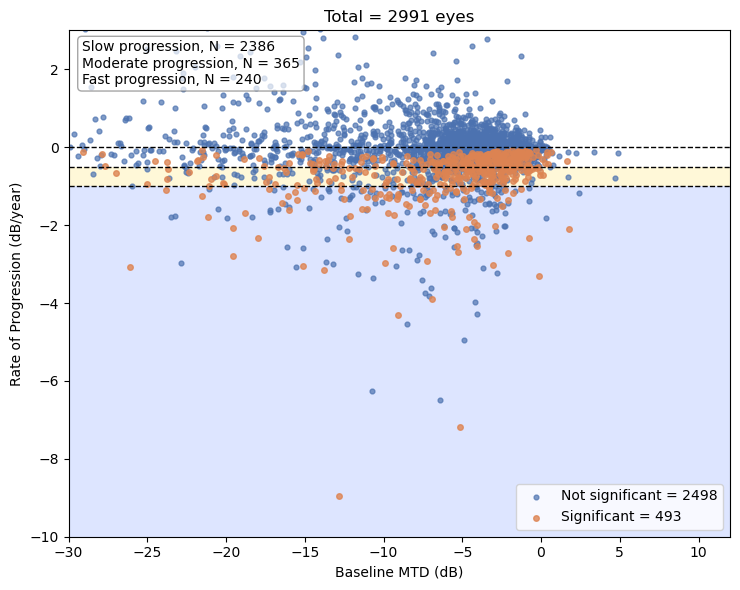

Saved figure -> /Users/v/Desktop/Visual/glaucoma_DL_project/results/figure1_style_progression_scatter.png


In [48]:
# ===== Progression rates per eye and Figure-1 style plot =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# For linear regression with p-values
from scipy.stats import linregress

# ---------- 1) Build per-eye time series and compute slopes ----------
# Keep only rows with numeric MTD and time
tmp = dfc.copy()
tmp["MTD"] = pd.to_numeric(tmp["MTD"], errors="coerce")
tmp["Time_from_Baseline"] = pd.to_numeric(tmp["Time_from_Baseline"], errors="coerce")
tmp = tmp.dropna(subset=["MTD","Time_from_Baseline"])

# Per-eye groups
eye_id = ["PatID","Eye"]
groups = tmp.sort_values(eye_id+["Time_from_Baseline"]).groupby(eye_id, sort=False)

records = []
for (pid, eye), g in groups:
    # eligibility: at least 4 tests for a reliable slope (paper’s practice)
    if len(g) < 4:
        continue
    
    t = g["Time_from_Baseline"].to_numpy()
    y = g["MTD"].to_numpy()
    
    # guard: require some temporal span
    if (t.max() - t.min()) <= 0:
        continue
    
    # linear regression: y = a * t + b
    lr = linregress(t, y)
    slope = lr.slope            # dB per year
    pval  = lr.pvalue           # two-sided p-value for slope != 0
    
    # baseline MTD = the row with t==0 if present; else earliest record
    base_row = g.loc[g["Time_from_Baseline"].idxmin()]
    baseline_mtd = float(base_row["MTD"])
    
    # per-eye metadata
    num_tests   = len(g)
    avg_interval = np.mean(np.diff(np.unique(t))) if len(np.unique(t))>1 else np.nan
    time_span    = float(t.max() - t.min())
    
    # significance: only count as “significant progression” if slope < 0 and p<0.05
    is_sig = (pval < 0.05) and (slope < 0)
    
    # speed category by slope (dB/year)
    if   slope <= -1.0:
        speed = "fast"
    elif slope <= -0.5:
        speed = "moderate"
    else:
        speed = "slow"
    
    records.append({
        "PatID": pid, "Eye": eye,
        "baseline_MTD": baseline_mtd,
        "slope_dByear": slope,
        "pvalue": pval,
        "significant": bool(is_sig),
        "num_tests": num_tests,
        "avg_interval": avg_interval,
        "time_span": time_span,
        "speed": speed
    })

prog_df = pd.DataFrame.from_records(records).reset_index(drop=True)

# ---------- 2) Quick summary (counts like the paper’s legend) ----------
N_total = len(prog_df)
N_sig   = int((prog_df["significant"]==True).sum())
N_nsig  = N_total - N_sig

N_slow      = int((prog_df["speed"]=="slow").sum())
N_moderate  = int((prog_df["speed"]=="moderate").sum())
N_fast      = int((prog_df["speed"]=="fast").sum())

print(f"Total eligible eyes = {N_total}")
print(f"Significant progression (p<0.05 & slope<0) = {N_sig}")
print(f"Not significant = {N_nsig}")
print(f"Slow progression = {N_slow}, Moderate = {N_moderate}, Fast = {N_fast}")

# ---------- 3) Save a CSV for inspection ----------
out_dir = Path("/Users/v/Desktop/Visual/glaucoma_DL_project/results")
out_dir.mkdir(parents=True, exist_ok=True)
prog_csv = out_dir / "per_eye_progression_summary.csv"
prog_df.to_csv(prog_csv, index=False)
print("Saved per-eye progression summary ->", prog_csv)

# ---------- 4) Figure-1 style scatter plot ----------
fig, ax = plt.subplots(figsize=(7.5, 6))

# Background shaded bands for speed thresholds (y = slope)
# fast (<= -1.0)
ax.axhspan(-10, -1.0, facecolor="#c7d4ff", alpha=0.6, zorder=0)  # blue-ish
# moderate (-1.0 .. -0.5)
ax.axhspan(-1.0, -0.5, facecolor="#fff4bf", alpha=0.6, zorder=0) # light yellow

# Reference lines
ax.axhline(0.0, color="k", linestyle="--", linewidth=1)
ax.axhline(-0.5, color="k", linestyle="--", linewidth=1)
ax.axhline(-1.0, color="k", linestyle="--", linewidth=1)

# Colors by significance
sig_mask = prog_df["significant"]==True
ax.scatter(prog_df.loc[~sig_mask, "baseline_MTD"],
           prog_df.loc[~sig_mask, "slope_dByear"],
           s=12, alpha=0.7, color="#4c72b0", label=f"Not significant = {N_nsig}")
ax.scatter(prog_df.loc[sig_mask, "baseline_MTD"],
           prog_df.loc[sig_mask, "slope_dByear"],
           s=16, alpha=0.8, color="#dd8452", label=f"Significant = {N_sig}")

ax.set_xlabel("Baseline MTD (dB)")
ax.set_ylabel("Rate of Progression (dB/year)")
ax.set_title(f"Total = {N_total} eyes")
ax.set_xlim(-30, 12)    
ax.set_ylim(-10, 3)

# Legend with speed counts
legend_text = (f"Slow progression, N = {N_slow}\n"
               f"Moderate progression, N = {N_moderate}\n"
               f"Fast progression, N = {N_fast}")

ax.text(0.02, 0.98, legend_text, transform=ax.transAxes,
        va="top", ha="left", fontsize=10,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, edgecolor="gray"))

ax.legend(loc="lower right", frameon=True)
plt.tight_layout()

fig_path = out_dir / "figure1_style_progression_scatter.png"
plt.savefig(fig_path, dpi=300)
plt.show()
print("Saved figure ->", fig_path)